In [3]:
import os
from os.path import join
from glob import glob 
import random
import shutil
import numpy as np
from pydub import AudioSegment
import tensorflow as tf
from scipy.io import wavfile
from scipy import signal
import math
from PIL import Image
import dlib
import skvideo.io
import time
import glob
import subprocess
import random
from PIL import Image
from scipy import signal
from scipy.io import wavfile
import math
import matplotlib.pyplot as plt
from pathlib import Path
import shutil
home = str(Path.home())
# Avoid printing TF log messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Video Part

In [99]:
def get_frames_mouth(detector, predictor, frames):
        MOUTH_WIDTH = 100
        MOUTH_HEIGHT = 50
        HORIZONTAL_PAD = 0.19
        normalize_ratio = None
        mouth_frames = []
        for frame in frames:
            dets = detector(frame, 1)
            shape = None
            for k, d in enumerate(dets):
                shape = predictor(frame, d)
                i = -1
            print(dets)
            if shape is None: # Detector doesn't detect face, just return as is
                return frames
            mouth_points = []
            for part in shape.parts():
                i += 1
                if i < 48: # Only take mouth region
                    continue
                mouth_points.append((part.x,part.y))
            np_mouth_points = np.array(mouth_points)

            mouth_centroid = np.mean(np_mouth_points[:, -2:], axis=0)

            if normalize_ratio is None:
                mouth_left = np.min(np_mouth_points[:, :-1]) * (1.0 - HORIZONTAL_PAD)
                mouth_right = np.max(np_mouth_points[:, :-1]) * (1.0 + HORIZONTAL_PAD)

                normalize_ratio = MOUTH_WIDTH / float(mouth_right - mouth_left)

            new_img_shape = (int(frame.shape[1] * normalize_ratio), int(frame.shape[0]* normalize_ratio))
            #resized_img = imresize(frame, new_img_shape)
            resized_img=np.array(Image.fromarray(frame).resize(new_img_shape))

            mouth_centroid_norm = mouth_centroid * normalize_ratio

            mouth_l = int(mouth_centroid_norm[0] - MOUTH_WIDTH / 2)
            mouth_r = int(mouth_centroid_norm[0] + MOUTH_WIDTH / 2)
            mouth_t = int(mouth_centroid_norm[1] - MOUTH_HEIGHT / 2)
            mouth_b = int(mouth_centroid_norm[1] + MOUTH_HEIGHT / 2)

            mouth_crop_image = resized_img[mouth_t:mouth_b, mouth_l:mouth_r]

            mouth_frames.append(mouth_crop_image)
        return mouth_frames

In [100]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [95]:
def get_video_frames(path):
        videogen = skvideo.io.vreader(path)
        frames = np.array([frame for frame in videogen])
        return frames

In [37]:
def get_cropped_video(input_vid, output_dest, detector = detector, predictor = predictor):
    
    frames=get_video_frames(input_vid)
    shape_input = frames.shape
    
    mouth=get_frames_mouth(detector, predictor, frames)
    outputdata = np.asarray(mouth)
    shape_output = outputdata.shape
    print(shape_output)
    print(input_vid)
    
    if shape_input != shape_output and len(shape_output)==4:
        writer = skvideo.io.FFmpegWriter(output_dest)
        for i in range(outputdata.shape[0]):
                writer.writeFrame(outputdata[i, :, :, :])
        writer.close()

In [101]:
frames = get_video_frames(files_video[4])

In [102]:
get_frames_mouth(detector, predictor, frames)

rectangles[[(46, 7) (135, 96)]]
rectangles[[(44, -16) (151, 104)]]
rectangles[[(46, 7) (135, 96)]]
rectangles[[(46, 7) (135, 96)]]
rectangles[[(46, 7) (135, 96)]]
rectangles[[(46, 7) (135, 96)]]
rectangles[[(46, 7) (135, 96)]]
rectangles[[(46, 7) (135, 96)]]
rectangles[[(46, 7) (135, 96)]]
rectangles[[(46, 7) (135, 96)]]
rectangles[[(44, -16) (151, 104)]]
rectangles[[(44, -16) (151, 104)]]
rectangles[[(46, 7) (135, 96)]]
rectangles[[(44, 8) (151, 116)]]
rectangles[[(44, -16) (151, 104)]]
rectangles[[(44, -16) (151, 104)]]
rectangles[[(44, -16) (151, 104)]]
rectangles[[(44, -16) (151, 104)]]
rectangles[[(44, -16) (151, 104)]]
rectangles[[(44, -16) (151, 104)]]
rectangles[[(44, -16) (151, 104)]]
rectangles[[(46, 7) (135, 96)]]
rectangles[[(44, -16) (151, 104)]]
rectangles[[(44, -16) (151, 104)]]
rectangles[[(44, 8) (151, 116)]]
rectangles[[(46, 7) (135, 96)]]
rectangles[[(46, 7) (135, 96)]]
rectangles[[(32, 8) (139, 116)]]
rectangles[[(36, 17) (126, 106)]]
rectangles[[(36, 17) (126, 106)

rectangles[[(32, 8) (139, 116)]]
rectangles[[(32, 8) (139, 116)]]
rectangles[[(32, 8) (139, 116)]]
rectangles[[(32, 8) (139, 116)]]
rectangles[[(46, 7) (135, 96)]]
rectangles[[(32, 8) (139, 116)]]
rectangles[[(46, 7) (135, 96)]]
rectangles[[(46, 7) (135, 96)]]
rectangles[[(32, 8) (139, 116)]]
rectangles[[(32, 8) (139, 116)]]
rectangles[[(32, 8) (139, 116)]]
rectangles[[(32, 8) (139, 116)]]
rectangles[[(32, 8) (139, 116)]]
rectangles[[(32, 8) (139, 116)]]
rectangles[[(32, 8) (139, 116)]]
rectangles[[(32, 8) (139, 116)]]
rectangles[[(32, 8) (139, 116)]]
rectangles[[(32, 8) (139, 116)]]
rectangles[[(32, 8) (139, 116)]]
rectangles[[(46, 7) (135, 96)]]
rectangles[[(46, 7) (135, 96)]]
rectangles[[(46, 7) (135, 96)]]
rectangles[[(46, 17) (135, 106)]]
rectangles[[(46, 17) (135, 106)]]
rectangles[[(46, 17) (135, 106)]]
rectangles[[(32, 8) (139, 116)]]
rectangles[[(36, 17) (126, 106)]]
rectangles[[(36, 17) (126, 106)]]
rectangles[[(36, 17) (126, 106)]]
rectangles[[(36, 17) (126, 106)]]


[array([[[189, 143, 127],
         [191, 145, 129],
         [192, 146, 130],
         ...,
         [131, 142, 131],
         [126, 137, 126],
         [124, 132, 120]],
 
        [[187, 141, 125],
         [190, 144, 128],
         [190, 144, 128],
         ...,
         [131, 142, 131],
         [126, 137, 126],
         [124, 132, 120]],
 
        [[189, 143, 127],
         [189, 143, 127],
         [189, 143, 127],
         ...,
         [131, 142, 131],
         [126, 137, 126],
         [124, 132, 120]],
 
        ...,
 
        [[147, 106,  88],
         [146, 105,  87],
         [146, 105,  87],
         ...,
         [123, 133, 125],
         [117, 127, 119],
         [113, 121, 111]],
 
        [[147, 106,  88],
         [146, 105,  87],
         [146, 105,  87],
         ...,
         [123, 133, 125],
         [117, 127, 119],
         [113, 121, 111]],
 
        [[145, 104,  86],
         [145, 104,  86],
         [145, 104,  86],
         ...,
         [123, 133, 125],
  

In [8]:
# To read the images in numerical order
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [31]:
files_video = sorted(glob.glob('/Users/manideepkolla/Downloads/test_fold/pretrain/*/*.mp4'), key=numericalSort)

In [38]:
# Calculate Lip crops for all the videos

for video in files_video:
    output_path = video[:-4]+'_lips.mp4'
    get_cropped_video(video, output_path, detector = detector, predictor = predictor)

(254, 50, 100, 3)
/Users/manideepkolla/Downloads/test_fold/pretrain/5538021026230548229/00003.mp4
(166, 50, 100, 3)
/Users/manideepkolla/Downloads/test_fold/pretrain/5538021026230548229/00004.mp4
(169, 160, 160, 3)
/Users/manideepkolla/Downloads/test_fold/pretrain/5538021026230548229/00006.mp4
(97, 160, 160, 3)
/Users/manideepkolla/Downloads/test_fold/pretrain/5538021026230548229/00007.mp4
(277, 50, 100, 3)
/Users/manideepkolla/Downloads/test_fold/pretrain/5538021026230548229/00009.mp4
(113, 160, 160, 3)
/Users/manideepkolla/Downloads/test_fold/pretrain/5538021026230548229/00012.mp4
(272, 160, 160, 3)
/Users/manideepkolla/Downloads/test_fold/pretrain/5542072039384139495/00002.mp4
(204, 160, 160, 3)
/Users/manideepkolla/Downloads/test_fold/pretrain/5542072039384139495/00005.mp4
(219, 160, 160, 3)
/Users/manideepkolla/Downloads/test_fold/pretrain/5542072039384139495/00008.mp4
(350, 160, 160, 3)
/Users/manideepkolla/Downloads/test_fold/pretrain/5542072039384139495/00009.mp4
(110, 160, 160

(92, 50, 100, 3)
/Users/manideepkolla/Downloads/test_fold/pretrain/5570529633693972071/00019.mp4
(204, 50, 100, 3)
/Users/manideepkolla/Downloads/test_fold/pretrain/5570529633693972071/00021.mp4
(104, 160, 160, 3)
/Users/manideepkolla/Downloads/test_fold/pretrain/5570529633693972071/00023.mp4
(331, 160, 160, 3)
/Users/manideepkolla/Downloads/test_fold/pretrain/5570529633693972071/00027.mp4
(376, 50, 100, 3)
/Users/manideepkolla/Downloads/test_fold/pretrain/5570529633693972071/00031.mp4
(234, 50, 100, 3)
/Users/manideepkolla/Downloads/test_fold/pretrain/5570529633693972071/00032.mp4
(252, 160, 160, 3)
/Users/manideepkolla/Downloads/test_fold/pretrain/5570529633693972071/00034.mp4
(112, 160, 160, 3)
/Users/manideepkolla/Downloads/test_fold/pretrain/5570529633693972071/00036.mp4
(111, 160, 160, 3)
/Users/manideepkolla/Downloads/test_fold/pretrain/5570529633693972071/00037.mp4


ValueError: could not broadcast input array from shape (50,100,3) into shape (50)

In [60]:
import cv2
import numpy as np

mouth_cascade = cv2.CascadeClassifier('./haarcascade_mcs_mouth.xml')
face_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')

if mouth_cascade.empty():
  raise IOError('Unable to load the mouth cascade classifier xml file')

img = frame
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray,1.5,12)
for(x,y,w,h) in faces:
        cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,0),2)
        roi_gray = gray[y:y+h, x:x+h]
        roi_color = img[y:y+h, x:x+h]
        mouth = mouth_cascade.detectMultiScale(roi_gray,2.0,25)
        for (ex, ey, ew, eh) in mouth:
            cv2.rectangle(img, (ex,ey), (ex+ew, ey+eh),(0,255,0),3)
        crop_img = img[ey:ey+eh, ex:ex+ew]
        cv2.imshow('Cropped mouth', crop_img)
        cv2.waitKey(0)

In [43]:
mouth_cascade = cv2.CascadeClassifier('./haarcascade_mcs_mouth.xml')
face_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')

In [98]:
def get_video_frames(path):

    cap = cv2.VideoCapture(path)
    frames = []

    while True:
        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)

        # Break the loop
        else: 
            break

    cap.release()
    return np.asarray(frames)

In [96]:
a = get_video_frames(files_video[4])

In [91]:
a.shapefiles_video[4]

(277, 160, 160, 3)

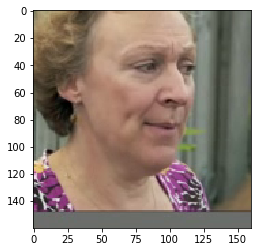

In [97]:
plt.imshow(a[15])

In [65]:
files_video.index('/Users/manideepkolla/Downloads/test_fold/pretrain/5570529633693972071/00037.mp4')

93

In [63]:
plt.imshow(crop_img)

NameError: name 'crop_img' is not defined

# Audio Part

In [10]:
def Reverse(lst): 
    return [ele for ele in reversed(lst)]

In [11]:
# For mixing two audios

def two_files_audio_sum(file_1_path, file_2_path,file_sum_name, volume_reduction=0):
    s1 = AudioSegment.from_file(file_1_path)
    s2 = AudioSegment.from_file(file_2_path) - volume_reduction # volume_reduction in dB

    s2_shift = (len(s1)-len(s2)) / 2 if len(s1) > len(s2) else 0
    
    audio_sum = s1.overlay(s2, position=s2_shift)
    audio_sum.export(file_sum_name, format='wav')

    return np.array(audio_sum.get_array_of_samples())

In [12]:
# Function to mix any number of audios

def audios_sum(audio_filenames_list,file_sum_name, volume_reduction=0):
    
    s = []
    for i, audio_file in enumerate(audio_filenames_list):
        
        if i == 0:
            s1 = AudioSegment.from_file(audio_file)
            s.append(s1)
        else:
            s1 = AudioSegment.from_file(audio_file) - volume_reduction # volume_reduction in dB
            s.append(s1)
    
    # Lenghts of audios
    s_len = []
    for i in s:
        l = len(i)
        s_len.append(l)
        
    # Sort elements in s according to their length
    s = [x for _,x in sorted(zip(s_len,s), reverse=True)]
    
    s_shift = []
    for i, item in enumerate(s):
        
        if i == 0:
            s_shift1 = item
            s_shift.append(s_shift1)
            
        else:
            s_shift1 = (len(s[0])-len(item)) / 2 if len(s[0]) > len(item) else 0
            s_shift.append(s_shift1)
            
    for i in range(len(s)):
        
        if i == 0:
            audio_sum = s[0]
            
        elif i > 0:
            audio_sum = audio_sum.overlay(s[i], position=s_shift[i])

    audio_sum.export(file_sum_name, format='wav')

    return np.array(audio_sum.get_array_of_samples())

In [13]:
mixed_samples=two_files_audio_sum('/Users/manideepkolla/Downloads/test_files/audios/H6jHEcXwbcg/00097.m4a','/Users/manideepkolla/Downloads/test_files/audios/H6jHEcXwbcg/00096.m4a','./mixed_audio.wav')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/manideepkolla/Downloads/test_files/audios/H6jHEcXwbcg/00097.m4a'

In [14]:
def downsampling(samples, sample_rate, downsample_rate):
    secs = len(samples) / float(sample_rate)
    num_samples = int(downsample_rate * secs)

    return signal.resample(samples, num_samples)

In [15]:
def compute_spectrograms(audio_file, max_audio_length=500000, sample_rate=16e3, n_fft=512, window_size=25, step_size=10):
    
    
    
    window_frame_size = int(round(window_size / 1e3 * sample_rate))
    step_frame_size = int(round(step_size  / 1e3 * sample_rate))
    
    audio_samples = np.zeros((1, max_audio_length + n_fft//2))
    
    
    rate, samples = wavfile.read(audio_file)
    samples = downsampling(samples, rate, sample_rate)
    audio_samples[0, n_fft//2: len(samples) + n_fft//2] = samples
    num_frames = math.ceil(float(len(samples) + n_fft//2) / step_frame_size)
    
    '''audio_samples = np.zeros((1, max_audio_length))
    
    
    rate, samples = wavfile.read(audio_file)
    #samples = downsampling(samples, rate, sample_rate)
    audio_samples[0, : len(samples)] = samples
    num_frames = math.ceil(float(len(samples)) / step_frame_size)'''
    
    # Create Graph
    with tf.Graph().as_default():
        samples_tensor = tf.constant(audio_samples, dtype=tf.float32)
        # Compute STFT
        specs_tensor = tf.contrib.signal.stft(samples_tensor, frame_length=window_frame_size, frame_step=step_frame_size,
                                              fft_length=n_fft, pad_end=True)
        # Apply power-law compression
        specs_tensor = tf.abs(specs_tensor) ** 0.3
    
        # Start session
        with tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                              log_device_placement=False)) as sess:
            specs = sess.run(specs_tensor)

    return specs, num_frames

In [19]:
s,n=compute_spectrograms(files_audio[5])

W0907 21:13:34.462671 4584711616 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [20]:
useful_frames=s[0][:n,:]

In [131]:
s.shape

(455, 257)

In [85]:
frames=get_video_frames(files_audio[2][:-3]+'mp4')

In [86]:
frames.shape

(169, 160, 160, 3)

In [12]:
import seaborn as sns
sns.set()

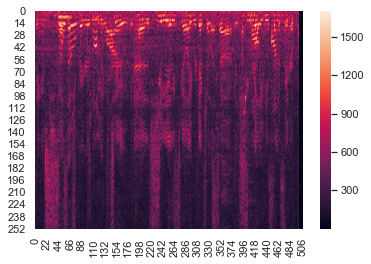

In [13]:
ax = sns.heatmap(np.rollaxis(useful_frames,1,0))

# Binary Mask Generation

In [21]:
def downsampling(samples, sample_rate, downsample_rate):
    secs = len(samples) / float(sample_rate)
    num_samples = int(downsample_rate * secs)

    return signal.resample(samples, num_samples)

In [22]:
# TF constants definition
TF_INTRA_OP_PT = int(os.getenv('TF_INTRA_OP', 0))
TF_INTER_OP_PT = int(os.getenv('TF_INTER_OP', 0))

# For single audio file

'''
Note: The training objective for VL2M is a Target Binary Mask (TBM), 
computed using the spectrogram of the tar- get speaker only. This 
is motivated by our goal of extracting the speech of a target speaker 
as much as possible indepen- dently of the concurrent speakers, so that, 
e.g., we do not need to estimate their number. An additional motivations 
is that the model takes as only input the visual features of the target 
speaker, and a target TBM that only depends on the target speaker allows 
VL2M to learn a function (rather than approximating an ill-posed one-to-many mapping).
'''

def ltass_speaker(audio_file, sample_rate=16e3, max_audio_length=1000000, window_size=25, step_size=10, n_samples=1000):
    """
    Compute the speaker Long-Term Average Speech Spectrum of a speaker.
    """
    
    audio_sample = np.zeros((max_audio_length))
    
    window_frame_size = int(round(window_size / 1e3 * sample_rate))
    step_frame_size = int(round(step_size  / 1e3 * sample_rate))
    
    rate, samples = wavfile.read(audio_file)
    samples = downsampling(samples, rate, sample_rate)
    audio_sample[:len(samples)] = samples
    num_frames = len(samples) // step_frame_size
    
    # Create Graph
    with tf.Graph().as_default():
        samples_tensor = tf.constant(audio_sample, dtype=tf.float32)
        # Compute STFT
        spec_tensor = tf.contrib.signal.stft(samples_tensor, frame_length=window_frame_size, frame_step=step_frame_size, pad_end=False)
        # Apply power-law compression
        spec_tensor = tf.abs(spec_tensor) ** 0.3
        
        # Start session
        with tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                              log_device_placement=False,
                                              intra_op_parallelism_threads=TF_INTRA_OP_PT,
                                              inter_op_parallelism_threads=TF_INTER_OP_PT)) as sess:
            spec = sess.run(spec_tensor)

    nf = num_frames
    spectrogram = spec[:nf]
    
    mean_spec = spectrogram.mean()
    stdev_spec = spectrogram.std()
    
    return mean_spec, stdev_spec, spec


def compute_tbm(audio_file, mask_threshold, sample_rate=16e3, max_audio_length=500000, n_fft=512, window_size=25, step_size=10):
    """
    Compute TBMs using LTASS.
    """
    #audio_filenames = sorted(glob(join(audio_folder, '*.wav')))
    #num_frames = np.zeros(len(audio_filenames), dtype=np.int32)
    
    window_frame_size = int(round(window_size / 1e3 * sample_rate))
    step_frame_size = int(round(step_size  / 1e3 * sample_rate))
    
    audio_sample = np.zeros((max_audio_length + n_fft//2))
    
    #for i, wav_file in enumerate(audio_filenames):
    rate, samples = wavfile.read(audio_file)
    samples = downsampling(samples, rate, sample_rate)
    audio_sample[n_fft//2: len(samples) + n_fft//2] = samples
    num_frames = math.ceil(float(len(samples) + n_fft//2) / step_frame_size)
    
    # Create Graph
    with tf.Graph().as_default():
        samples_tensor = tf.constant(audio_sample, dtype=tf.float32)
        # Compute STFT
        spec_tensor = tf.contrib.signal.stft(samples_tensor, frame_length=window_frame_size, frame_step=step_frame_size, pad_end=True)
        spec_tensor = tf.abs(spec_tensor)

        # Start session
        with tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                              log_device_placement=False,
                                              intra_op_parallelism_threads=TF_INTRA_OP_PT,
                                              inter_op_parallelism_threads=TF_INTER_OP_PT)) as sess:
            spec = sess.run(spec_tensor)
            
    mask = spec > mask_threshold
    
    return audio_file, mask, num_frames

def save_target_binary_mask_speaker(audio_file, mask_file, mask_factor=0.5, sample_rate=16e3, max_audio_length=500000, ltass_samples=1000):
    
    # Compute thresholds and spectrograms
    #print('Computing LTASS threshold...')
    
    rate, samples = wavfile.read(audio_file)
    samples = downsampling(samples, rate, sample_rate)
    shape_ = samples.shape
    
    if len(shape_)==1:
        
        threshold_mean, threshold_std, _ = ltass_speaker(audio_file, sample_rate, max_audio_length=max_audio_length, n_samples=ltass_samples)
        # Denormalize
        threshold_freq = (threshold_mean + threshold_std * mask_factor) ** (1 / 0.3)

        #print('done.')
        #print('Threshold shape:', threshold_freq.shape)

        # Compute binary masks
        audio_filename, mask, num_frames = compute_tbm(audio_file, threshold_freq, sample_rate, max_audio_length=max_audio_length)

        #for a_file, mask, nf in zip(audio_filenames, masks, num_frames):
        #s_file = os.path.join(audio_file[:-3]+'.npy')
        nf = num_frames
        np.save(mask_file, mask[:nf])

        #print('Done. Target Binary Masks generated:', len(audio_filenames))
        
    elif len(shape_)==2:
        
        print(audio_file)
        garb = np.asarray([0])
        np.save('garbage.npy', garb)

In [53]:
# Calculate Binary Masks for all the audios

for audio in files_audio:
    output_path = audio[:-4]+'_mask.npy'
    save_target_binary_mask_speaker(audio, mask_file = output_path)

/Users/manideepkolla/Downloads/test_fold/pretrain/5971440779089133573/00010.wav


ValueError: could not broadcast input array from shape (568320) into shape (500000)

In [105]:
save_target_binary_mask_speaker(files_audio[5], mask_file = '5.npy')

In [26]:
files_audio[3],

('/Users/manideepkolla/Downloads/test_fold/pretrain/5538021026230548229/00007.wav',)

In [39]:
sums = two_files_audio_sum(files_audio[4], files_audio[5],file_sum_name = 'sum4_5.wav')

In [41]:
len(sums)

178176

In [24]:
s,n=compute_spectrograms('sum4_3.wav')

In [25]:
useful_frames_sum=s[0][:n,:]

In [44]:
useful_frames_sum.shape

(1116, 257)

In [118]:
mask = np.load('5.npy')

In [70]:
mask

array([[False, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [71]:
mask.shape

(456, 257)

In [115]:
filtered = np.multiply(useful_frames_sum, mask)

In [116]:
filtered

array([[19.318544, 19.355839, 19.365398, ...,  0.      ,  0.      ,
         0.      ],
       [22.351877, 23.902485, 19.739388, ...,  0.      , 13.439726,
        14.592515],
       [20.136927, 23.731195, 27.718866, ...,  0.      , 13.006953,
         0.      ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)

In [64]:
s,n=compute_spectrograms(files_audio[5])
useful_frames=s[0][:n,:]

In [112]:
useful_frames_sum

array([[1.9318544e+01, 1.9355839e+01, 1.9365398e+01, ..., 8.5857258e+00,
        9.4395761e+00, 9.7315226e+00],
       [2.2351877e+01, 2.3902485e+01, 1.9739388e+01, ..., 1.0559887e+01,
        1.3439726e+01, 1.4592515e+01],
       [2.0136927e+01, 2.3731195e+01, 2.7718866e+01, ..., 1.2634775e+01,
        1.3006953e+01, 4.7588387e+00],
       ...,
       [6.0328463e-04, 7.1801490e-04, 8.2684943e-04, ..., 2.0783833e-04,
        3.3462324e-04, 3.4469282e-04],
       [3.8957247e-04, 5.3706276e-04, 6.5200322e-04, ..., 3.5074042e-04,
        3.3121184e-04, 3.2618636e-04],
       [2.2899258e-04, 2.2894883e-04, 2.2881637e-04, ..., 8.4257139e-05,
        6.8525653e-05, 2.2063581e-05]], dtype=float32)

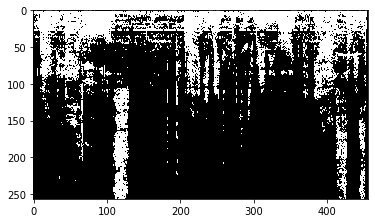

In [119]:
plt.imshow(np.transpose(mask), cmap='gray')

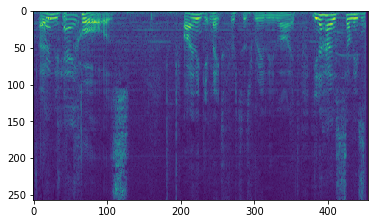

In [135]:
plt.imshow(np.transpose(useful_frames))

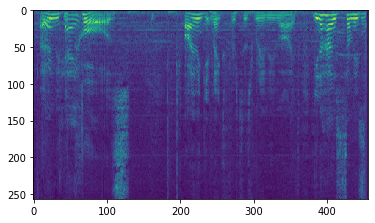

In [139]:
plt.imshow(np.transpose(useful_frames))

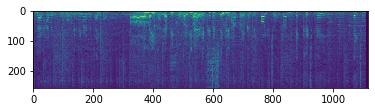

In [114]:
plt.imshow(np.transpose(useful_frames_sum))

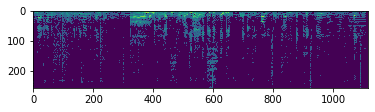

In [117]:
plt.imshow(np.transpose(filtered))

In [95]:
# ISTFT

t, x = signal.istft(useful_frames, fs=1/16e3)

In [96]:
t.shape

(116480,)

In [97]:
import scipy
scipy.io.wavfile.write('out.wav', 16000, x)

# Test Masks

In [1]:
def rbm(Zsamples2, Zmixed_series):
    #Calculate signal to noise ratio of clean signal versus combined signal (for speaker 2)
    snr2 = np.divide(np.abs(Zsamples2), np.abs(Zmixed_series))  # dividing denominator may be 0, so there will be nan

    # Round snr to 0 or 1 to create binary mask
    mask2 = np.around(snr2, 0)

    # Convert all nan in mask to 1 (it shouldnt matter if this is 0 or 1)
    mask2[np.isnan(mask2)] = 1

    # Replace all values over 1 with 1
    mask2[mask2 > 1] = 1
    return mask2

In [ ]:
#Get stft of 3 wav files
f1, t1, Zsamples1 = signal.stft(samples1, fs=sample_rate1, nperseg=nperseg)
f2, t2, Zsamples2 = signal.stft(samples2, fs=sample_rate1, nperseg=nperseg)
fmixed, tmixed, Zmixed_series = signal.stft(mixed_series, fs=sample_rate1, nperseg=nperseg)

# Organising Files and extracting audio

In [177]:
files = sorted(glob.glob('/Users/manideepkolla/Downloads/test_fold/pretrain/*/*.mp4'), key=numericalSort)

In [178]:
files_split = []
for i in files:
    files_split.append(i.split('/'))

In [47]:
len(files)

0

In [18]:
# Extract audio and save as .wav files 

def get_wav(mp4_file):
    
    out_path = mp4_file[:-3]+"wav"
    #print(out_path)
    command = "ffmpeg -i " + mp4_file + ' -codec:a' + ' pcm_s16le' + ' -ac' + ' 1 ' + out_path
    subprocess.call(command, shell=True)

In [181]:
for item in files:
    get_wav(item)

In [19]:
def compare_lengths(file_1_path, file_2_path, max_duration_diff=2000):
    # max_duration_diff in milliseconds
    s1 = AudioSegment.from_file(file_1_path)
    s2 = AudioSegment.from_file(file_2_path)
   
    return abs(len(s1) - len(s2)) < max_duration_diff

In [18]:
compare_lengths(files[3], files[0])

False

In [28]:
files_audio = sorted(glob.glob('/Users/manideepkolla/Downloads/test_fold/pretrain/*/*.wav'), key=numericalSort)

In [65]:
len(files_audio)

2822

In [46]:
files = sorted(glob.glob('/Users/manideepkolla/Downloads/lrs2/mvlrs_v1/pretrain/*.mp4'), key=numericalSort)

In [29]:
lens = []
for i in files_audio:
    ps = AudioSegment.from_file(i)
    lens.append(len(ps))

In [30]:
lens

[10176,
 6656,
 6784,
 3904,
 11136,
 4544,
 10880,
 8192,
 8768,
 14016,
 4416,
 6016,
 8576,
 10304,
 3904,
 8512,
 9088,
 6208,
 5120,
 5312,
 11008,
 7552,
 6976,
 8640,
 9088,
 5056,
 3520,
 17728,
 5888,
 8448,
 5248,
 8448,
 8768,
 4352,
 5312,
 14144,
 11904,
 9088,
 6528,
 11200,
 6528,
 6336,
 3776,
 9152,
 10496,
 6720,
 10560,
 7872,
 5056,
 5248,
 8256,
 5056,
 7872,
 12288,
 5632,
 5440,
 3840,
 4608,
 11712,
 12160,
 9728,
 3520,
 4608,
 13632,
 11840,
 3648,
 4928,
 9152,
 8640,
 9536,
 4288,
 7296,
 12288,
 5376,
 3520,
 3328,
 4416,
 5632,
 6016,
 7168,
 5312,
 3648,
 9088,
 5376,
 11392,
 3712,
 8192,
 4160,
 13248,
 15040,
 9408,
 10112,
 4480,
 4480,
 6848,
 5824,
 3520,
 20416,
 9600,
 12928,
 19072,
 17728,
 4736,
 25536,
 7040,
 6592,
 4480,
 14528,
 11136,
 10688,
 3968,
 4160,
 7680,
 4416,
 5120,
 5056,
 3520,
 5440,
 12736,
 5504,
 6720,
 11136,
 7616,
 4096,
 9600,
 5056,
 3520,
 5568,
 10432,
 4608,
 6208,
 10048,
 10752,
 5056,
 4288,
 12608,
 3648,
 4096

In [23]:
files_audio_7to10 = []
for i,lenn in enumerate(lens):
    if lenn > 7000 and lenn<=10000:
        files_audio_7to10.append(files_audio[i])

In [24]:
len(files_audio_7to10)

478

In [26]:
# From all the existing files, pick certain number files randomly and pair certain number of them together. (Just the file names)
def pair_files(files, combination_no=1, count=10):
    
    if combination_no <= 0 or count <= 0:
        print('Inputs not valid')
        return 0
    
    combined_list = []
    
    picks_no = combination_no*count
    
    #a = time.time()
    for n, item in enumerate(files):
        #print(n)
        
        #global files_copy
        
        files_copy = files[:]
        files_copy.remove(item)
        
        if len(combined_list)>0:
            if combination_no == 1:
                for done in combined_list:
                    if item in done:
                        index = done.index(item)
                        del_index = int(not index)
                        del_file = done[del_index]
                        files_copy.remove(del_file)
                        
        '''# Get the audio files with difference of > 2 seconds
        files_copy_not_2secs = []
        files_copy1 = files_copy[:]
        for i in files_copy1:
            if not compare_lengths(item, i):
                files_copy.remove(i)'''
                
        count_ = 0 
        picks = []
        while count_<=picks_no:
            pick = random.sample(files_copy, 1)[0]
            #print(pick)
            files_copy.remove(pick)
            if compare_lengths(item, pick):
                count_ += 1
                picks.append(pick)
            
        # Sample the audios from the filtered filelist
        random.seed(1)
        picks = random.sample(files_copy, picks_no)
        #print(len(files_copy))
        
        for i in range(count):
            
            if combination_no == 1:
                random.seed(2)
                picked = random.sample(picks, combination_no)
                
                combined = [0]*2
                combined[0] = item
                combined[1] = picked

                picks = [e for e in picks if e is not picked]
                
            else:
                
                random.seed(3)
                picked = random.sample(picks, combination_no)
                
                picks = [e for e in picks if e is not picked]
                
                picked.append(item)
                
                combined = picked
                
            combined_list.append(combined)
        #b = time.time()
        #print(n, 'Seconds', b-a)
            
    return combined_list

In [27]:
combined_list = pair_files(files_audio_7to10, combination_no=1, count=5)

In [28]:
len(combined_list)

2390

# Generate final Training/Val/Testing folders

### Directory structure

```
TRAINING_SET

    s1_1
        /lips.mp4
        /mixed_spectrogram.png
        /mask.png
    s1_2
        /lips.mp4
        /mixed_spectrogram.png
        /mask.png
    ...
    
    s2_1
        /lips.mp4
        /mixed_spectrogram.png
        /mask.png
    s2_2
        /lips.mp4
        /mixed_spectrogram.png
        /mask.png
    ...

```

In [ ]:
# Generate training folders for one combination (Modified)

def gen_comb_folders(combined_pairs, dest_folder):
    
    try:
        os.mkdir(dest_folder)
    except OSError:
        pass

    videos = combined_pairs
    audios = []
    masks = []
    
    for item in videos:
        audio = item[:-9] + '.wav'
        audios.append(audio)
        
    for item in videos:
        mask = item[:-9] + '_mask.npy'
        masks.append(mask)
    
    folder_name = videos[-1].split('/')[-2] + '_' + videos[-1][:-4].split('/')[-1]
    folder_path = dest_folder + '/' + folder_name
        
    spectrograms = []
    frames = []
    for i in range(len(videos)):
        video = videos[i]
        audio = audios[i]
        
        # Get frames
        frame=get_video_frames(video)
        
        frames.append(frame)
        
    ## Now mix the audios and compute the spectrogram of mixed audio
        
    mix_audio_folder = home + '/mixed_audio_files'
        
    # Filename to save the mixed audio  file
    mixed_audio_filename = folder_name + '.wav'             
        
    mixed_audio_filepath = mix_audio_folder + '/' + mixed_audio_filename
        
    try:
        os.mkdir(mix_audio_folder)
    except OSError:
        pass
        
    mixed_samples = audios_sum(audios, mixed_audio_filepath)
        
    # Compute the spectrogram of mised audio
    s,n=compute_spectrograms(mixed_audio_filepath)
    mixed_spectogram =s[0][:n,:]                     # Useful frames
        

    for p in range(len(videos)):
            
        frame = frames[p]
        #mask = masks[p]
        audio_file = audios[p]
        lips_file = videos[p]
        mask_file = masks[p]
        
        save_path = folder_path + '_' + str(p)
        
        try:
            os.mkdir(save_path)
        except OSError:
            pass
            
        # Save lips.mp4
            
        shutil.copy2(lips_file, save_path)
            
        # Save the mask
            
        '''mask_file = save_path + '/' + 'mask.npy'
        # Computes the Target binary mask and save it in destination.
        save_target_binary_mask_speaker(audio_file, mask_file = mask_file)'''
        
        shutil.copy2(mask_file, save_path)
            
        # Save the mixed spectrogram
        np.save(save_path + '/' + 'mixed_spectrogram.png',mixed_spectogram)

In [430]:
a = gen_comb_folders(combined_list[1], dest_folder = '/Users/manideepkolla/Downloads/test_fold/output')

In [406]:
a[1][0]

'/Users/manideepkolla/Downloads/test_fold/pretrain/5549779787693549159/00001.mp4'

In [287]:
videos = ['/Users/manideepkolla/Downloads/test_fold/pretrain/5957285425744490519/00062.mp4', '/Users/manideepkolla/Downloads/test_fold/pretrain/5549779787693549159/00010.mp4', '/Users/manideepkolla/Downloads/test_fold/pretrain/5971440779089133573/00031.mp4', '/Users/manideepkolla/Downloads/test_fold/pretrain/6077451309242250656/00026.mp4', '/Users/manideepkolla/Downloads/test_fold/pretrain/5549779787693549159/00001.mp4']

In [ ]:
# Generate training folders for one combination (Modified)

def gen_comb_folders(combined_pairs, dest_folder):
    
    try:
        os.mkdir(dest_folder)
    except OSError:
        pass

    videos = combined_pairs
    audios = []
    
    for item in videos:
        audio = item[:-9] + '.wav'
        audios.append(audio)
    
    
    folder_name_list = []
    for path in audios:
        split_ = path.split('/')
        fold = split_[-2] + '_' + split_[-1][:-4]
        folder_name_list.append(fold)
        
    folder_name = '/'.join(folder_name_list)
    folder_path = dest_folder + '/' + folder_name
    
    ## Now mix the audios and compute the spectrogram of mixed audio
    
    mix_audio_folder = home + '/mixed_audio_files'
        
    # Filename to save the mixed audio  file
    mixed_audio_filename = folder_name + '.wav'             
        
    mixed_audio_filepath = mix_audio_folder + '/' + mixed_audio_filename
        
    try:
        os.mkdir(mix_audio_folder)
    except OSError:
        pass
    
    mixed_samples = audios_sum(audios, mixed_audio_filepath)
        
    # Compute the spectrogram of mised audio
    s,n=compute_spectrograms(mixed_audio_filepath)
    mixed_spectogram =s[0][:,:1000]                     # Useful frames
        

    for p in range(len(videos)):

        audio_file = audios[p]
        lips_file = videos[p]
        mask_file = masks[p]
        
        save_path = folder_path
        
        try:
            os.mkdir(save_path)
        except OSError:
            pass
            
        # Save lips.mp4
        
        file_name = audio_file_split[-2] + '_' + audio_file_split[-1][:-4] + '_lips.mp4'
            
        shutil.copy(lips_file, save_path + '/' + file_name)
            
        # Save the mask
        
        s, n = compute_spectrograms(audio_file)
        s_use=s[:, :1000]
        
        mask = ibm(spec_mix = mixed_spectogram,spec_signal = s_use,threshold=1)
        
        audio_file_split = audio_file.split('/')
        
        file_name = audio_file_split[-2] + '_' + audio_file_split[-1][:-4] + '_mask.npy'
        
        np.save(save_path + '/' + file_name, mask)
        
        shutil.copy(mask_file, save_path)
            
        # Save the mixed spectrogram
        np.save(save_path + '/' + 'mixed_spectrogram.png',mixed_spectogram)

In [428]:
# Generate training folders for one combination

def gen_comb_folders(combined_pairs, dest_folder):
    
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
    
    try:
        os.mkdir(dest_folder)
    except OSError:
        pass

    videos = combined_pairs
    audios = []
    
    for item in videos:
        audio = item[:-3] + 'wav'
        audios.append(audio)
        
    '''video_audio = [[0]*2]*len(combined_pairs)
    
    for i in range(len(video_audio)):
        #print(i)
        video_audio[i][0] = videos[i]
        #print(videos[i])
        video_audio[i][1] = audios[i]
        #print(audios[i])
        
    # Folder to save the files
    #print(video_audio)'''
    
    folder_name = videos[-1].split('/')[-2] + '_' + videos[-1][:-4].split('/')[-1]
    folder_path = dest_folder + '/' + folder_name
    #print(folder_path)
        
    spectrograms = []
    #masks = []
    frames = []
    for i in range(len(videos)):
        video = videos[i]
        audio = audios[i]
        
        # Get frames
        frame=get_video_frames(video)
        mouth=get_frames_mouth(detector, predictor, frame)
        
        frames.append(mouth)
        
        '''# Compute Spectrograms
        
        # Extract audio save as .wav
        get_wav(video)
        
        s,n=compute_spectrograms(audio) ## Need to compute (remaining)
        useful_frames=s[0][:n,:] ## Need to compute (remaining)
        
        spectrograms.append(useful_frames)'''
        
    ## Now mix the audios and compute the spectrogram of mixed audio
        
    mix_audio_folder = home + '/mixed_audio_files'
        
    # Filename to save the mixed audio  file
    mixed_audio_filename = folder_name + '.wav'             
        
    mixed_audio_filepath = mix_audio_folder + '/' + mixed_audio_filename
        
    try:
        os.mkdir(mix_audio_folder)
    except OSError:
        pass
        
    mixed_samples = audios_sum(audios, mixed_audio_filepath)
        
    # Compute the spectrogram of mised audio
    s,n=compute_spectrograms(mixed_audio_filepath)
    mixed_spectogram =s[0][:n,:]                     # Useful frames
        

    for p in range(len(videos)):
            
        frame = frames[p]
        #mask = masks[p]
        audio_file = audios[p]
            
        try:
            os.mkdir(folder_path + '_' + str(p))
        except OSError:
            pass
            
        # Save lips.mp4
            
        outputdata = np.asarray(frame)
        writer = skvideo.io.FFmpegWriter(folder_path + '_' + str(p)+ '/' + 'lips.mp4')
        for i in range(outputdata.shape[0]):
            writer.writeFrame(outputdata[i, :, :, :])
        writer.close()
            
        # Save the mask
        '''mask = Image.fromarray(mask)
        mask = mask.convert('RGB')
        im.save(folder_path + '_' + str(p)+ '/' + 'mask.png')'''
            
        mask_file = folder_path + '_' + str(p)+ '/' + 'mask.npy'
        # Computes the Target binary mask and save it in destination.
        save_target_binary_mask_speaker(audio_file, mask_file = mask_file)
            
        # Save the mixed spectrogram
        np.save(folder_path + '_' + str(p)+ '/' + 'mixed_spectrogram.png',mixed_spectogram)

In [104]:
a = ['a','b','c']

In [105]:
'/'.join(a)

'a/b/c'

start = time.time()
mouth=get_frames_mouth(detector, predictor, frames)
end = time.time()
print((end-start))

outputdata = np.asarray(mouth)

writer = skvideo.io.FFmpegWriter("outputvideo.mp4")
for i in range(outputdata.shape[0]):
        writer.writeFrame(outputdata[i, :, :, :])
writer.close()